# Keras U-Net starter - LB 0.277

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras import backend as K
import tensorflow.compat.v1.keras.backend as K

import tensorflow as tf

C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
from pathlib import Path

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

ROOT_DIR = Path('C:/Users/sinjy/jupyter_notebook/datasets')
DATA_DIR = ROOT_DIR / 'kaggle_datasets' / 'nuclei'
TRAIN_PATH = DATA_DIR / 'stage1_train'
TEST_PATH = DATA_DIR / 'stage1_test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Get the data

### resize image

In [4]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ...')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH / id_
    img = imread(path / 'images' / (id_ + '.png'))[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path / 'masks'))[2]:
        mask_ = imread(path / 'masks' / mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),
                               axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ...


C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

In [5]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ...')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH / id_
    img = imread(path / 'images' / (id_ + '.png'))[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ...


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.39it/s]

Done!


### check mask

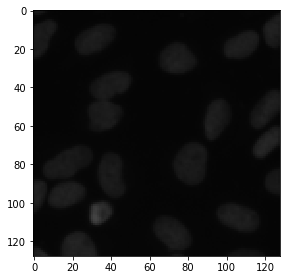

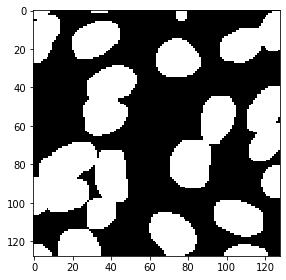

In [6]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Create our Keras metric

In [25]:
tf.config.run_functions_eagerly(True)
def mean_iou(y_true, y_pred):
    meaniou = tf.keras.metrics.MeanIoU(2)
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score = meaniou(y_true, y_pred_)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# class MeanIou(tf.keras.metrics.Metric):
#     def __init__(self):
#         super(MeanIou, self).__init__()
#         self.mean_iou = tf.keras.metrics.MeanIoU(2)
    
#     def update_state(self, y_true, y_pred, sample_weight=None):
#         prec = []
#         for t in np.arange(0.5, 1.0, 0.05):
#             y_pred_ = tf.cast(y_pred > t, tf.int32)
#             score = self.mean_iou(y_true, y_pred_)
#             prec.append(score)
#         self.ans =  K.mean(K.stack(prec), axis=0)
    
#     def result(self):
#         return self.ans

## Build and train our neural network

### Build U-Net model

In [26]:
class DownConv(tf.keras.layers.Layer):
    def __init__(self, filters, pool):
        super(DownConv, self).__init__()
        self.pool = pool
        self.c1 = Conv2D(
            filters, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same')
        self.dropout = Dropout(0.2)
        self.c2 = Conv2D(
            filters, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same')
        if pool:
            self.pool = MaxPooling2D((2, 2))
    def call(self, x):
        x = self.c1(x)
        x = self.dropout(x)
        c = self.c2(x)
        if self.pool:
            p = self.pool(c)
            return c, p
        return c

class UpConv(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(UpConv, self).__init__()
        self.ct1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), 
                                   padding='same')
        self.c1 = Conv2D(
            filters, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same')
        self.dropout = Dropout(0.2)
        self.c2 = Conv2D(
            filters, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same')
    def call(self, x, d):
        x = self.ct1(x)
        x = concatenate([x, d])
        x = self.c1(x)
        x = self.dropout(x)
        x = self.c2(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, filters_lst):
        super(Encoder, self).__init__()
        self.blocks = [DownConv(filters, True) for filters in filters_lst]
        self.conv = DownConv(256, False)
    def call(self, x):
        c_lst = []
        p = x
        for block in self.blocks:
            c, p = block(p)
            c_lst += [c]
        p = self.conv(p)
        return p, c_lst
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, filters_lst):
        super(Decoder, self).__init__()
        self.blocks = [UpConv(filters) for filters in filters_lst[::-1]]
        self.conv = Conv2D(1, (1, 1), activation='sigmoid')
    def call(self, p, c_lst):
        for block, c in zip(self.blocks, c_lst[::-1]):
            p = block(p, c)
        p = self.conv(p)
        return p
    
class UNet(tf.keras.Model):
    def __init__(self, filters_lst=[16, 32, 64, 128]):
        super(UNet, self).__init__()
        self.scaler = Lambda(lambda x: x / 255)
        self.encoder = Encoder(filters_lst)
        self.decoder = Decoder(filters_lst)
    def call(self, x):
        x = self.scaler(x)
        p, c_lst = self.encoder(x)
        y = self.decoder(p, c_lst)
        return y
    def summary(self):
        x = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS])
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [27]:
model = UNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128, 128, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
encoder_5 (Encoder)             ((None, 8, 8, 256),  1178768     lambda_5[0][0]                   
__________________________________________________________________________________________________
decoder_5 (Decoder)             (None, 128, 128, 1)  762337      encoder_5[0][0]                  
                                                                 encoder_5[0][1]            

In [28]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(
    'C:/Users/sinjy/jupyter_notebook/model/model-dsbow', verbose=1, 
    save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, 
                   epochs=50, callbacks=[earlystopper, checkpointer])

C:\Users\sinjy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
38/38 [==============================] - 69s 2s/step - loss: 0.5038 - mean_iou: 0.4616 - val_loss: 0.2965 - val_mean_iou: 0.6488

Epoch 00001: val_loss improved from inf to 0.29648, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 2/50
38/38 [==============================] - 71s 2s/step - loss: 0.2781 - mean_iou: 0.7088 - val_loss: 0.1951 - val_mean_iou: 0.7872

Epoch 00002: val_loss improved from 0.29648 to 0.19506, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 3/50
38/38 [==============================] - 74s 2s/step - loss: 0.2031 - mean_iou: 0.7831 - val_loss: 0.1788 - val_mean_iou: 0.7950

Epoch 00003: val_loss improved from 0.19506 to 0.17877, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 4/50
38/38 [==============================] - 70s 2s/step - loss: 0.1735 - mean_iou: 0.8138 - val_loss: 0.1451 - val_mean_iou: 0.8344

Epoch 00004: val_loss improved from 0.17877 to 0.14513, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 5/50
38/38 [==============================] - 69s 2s/step - loss: 0.1584 - mean_iou: 0.8314 - val_loss: 0.1284 - val_mean_iou: 0.8614

Epoch 00005: val_loss improved from 0.14513 to 0.12841, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 6/50
38/38 [==============================] - 70s 2s/step - loss: 0.1441 - mean_iou: 0.8483 - val_loss: 0.1279 - val_mean_iou: 0.8673

Epoch 00006: val_loss improved from 0.12841 to 0.12786, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 7/50
38/38 [==============================] - 70s 2s/step - loss: 0.1373 - mean_iou: 0.8566 - val_loss: 0.1439 - val_mean_iou: 0.8531

Epoch 00007: val_loss did not improve from 0.12786
Epoch 8/50
38/38 [==============================] - 71s 2s/step - loss: 0.1307 - mean_iou: 0.8638 - val_loss: 0.1346 - val_mean_iou: 0.8731

Epoch 00008: val_loss did not improve from 0.12786
Epoch 9/50
38/38 [==============================] - 69s 2s/step - loss: 0.1277 - mean_iou: 0.8649 - val_loss: 0.1180 - val_mean_iou: 0.8705

Epoch 00009: val_loss improved from 0.12786 to 0.11798, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 10/50
38/38 [==============================] - 73s 2s/step - loss: 0.1163 - mean_iou: 0.8766 - val_loss: 0.1138 - val_mean_iou: 0.8810

Epoch 00010: val_loss improved from 0.11798 to 0.11383, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 11/50
38/38 [==============================] - 73s 2s/step - loss: 0.1112 - mean_iou: 0.8813 - val_loss: 0.1014 - val_mean_iou: 0.8912

Epoch 00011: val_loss improved from 0.11383 to 0.10135, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 12/50
38/38 [==============================] - 72s 2s/step - loss: 0.1099 - mean_iou: 0.8818 - val_loss: 0.0999 - val_mean_iou: 0.8970

Epoch 00012: val_loss improved from 0.10135 to 0.09986, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 13/50
38/38 [==============================] - 1044s 28s/step - loss: 0.1067 - mean_iou: 0.8863 - val_loss: 0.0938 - val_mean_iou: 0.8994

Epoch 00013: val_loss improved from 0.09986 to 0.09380, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 14/50
38/38 [==============================] - 70s 2s/step - loss: 0.1097 - mean_iou: 0.8835 - val_loss: 0.0970 - val_mean_iou: 0.8945

Epoch 00014: val_loss did not improve from 0.09380
Epoch 15/50
38/38 [==============================] - 71s 2s/step - loss: 0.1068 - mean_iou: 0.8851 - val_loss: 0.0925 - val_mean_iou: 0.9033

Epoch 00015: val_loss improved from 0.09380 to 0.09250, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 16/50
38/38 [==============================] - 69s 2s/step - loss: 0.1022 - mean_iou: 0.8911 - val_loss: 0.0949 - val_mean_iou: 0.8968

Epoch 00016: val_loss did not improve from 0.09250
Epoch 17/50
38/38 [==============================] - 69s 2s/step - loss: 0.0998 - mean_iou: 0.8923 - val_loss: 0.0850 - val_mean_iou: 0.9106

Epoch 00017: val_loss improved from 0.09250 to 0.08502, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 18/50
38/38 [==============================] - 69s 2s/step - loss: 0.1017 - mean_iou: 0.8919 - val_loss: 0.0945 - val_mean_iou: 0.8941

Epoch 00018: val_loss did not improve from 0.08502
Epoch 19/50
38/38 [==============================] - 70s 2s/step - loss: 0.0985 - mean_iou: 0.8944 - val_loss: 0.0908 - val_mean_iou: 0.9040

Epoch 00019: val_loss did not improve from 0.08502
Epoch 20/50
38/38 [==============================] - 70s 2s/step - loss: 0.0994 - mean_iou: 0.8927 - val_loss: 0.0874 - val_mean_iou: 0.9045

Epoch 00020: val_loss did not improve from 0.08502
Epoch 21/50
38/38 [==============================] - 69s 2s/step - loss: 0.0956 - mean_iou: 0.8967 - val_loss: 0.0846 - val_mean_iou: 0.9056

Epoch 00021: val_loss improved from 0.08502 to 0.08457, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 22/50
38/38 [==============================] - 70s 2s/step - loss: 0.0934 - mean_iou: 0.8981 - val_loss: 0.0841 - val_mean_iou: 0.9091

Epoch 00022: val_loss improved from 0.08457 to 0.08407, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 23/50
38/38 [==============================] - 223s 6s/step - loss: 0.0935 - mean_iou: 0.8986 - val_loss: 0.0807 - val_mean_iou: 0.9132

Epoch 00023: val_loss improved from 0.08407 to 0.08073, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 24/50
38/38 [==============================] - 69s 2s/step - loss: 0.0922 - mean_iou: 0.9005 - val_loss: 0.0911 - val_mean_iou: 0.8989

Epoch 00024: val_loss did not improve from 0.08073
Epoch 25/50
38/38 [==============================] - 70s 2s/step - loss: 0.0931 - mean_iou: 0.8981 - val_loss: 0.0848 - val_mean_iou: 0.9119

Epoch 00025: val_loss did not improve from 0.08073
Epoch 26/50
38/38 [==============================] - 71s 2s/step - loss: 0.0902 - mean_iou: 0.9023 - val_loss: 0.0850 - val_mean_iou: 0.9045

Epoch 00026: val_loss did not improve from 0.08073
Epoch 27/50
38/38 [==============================] - 70s 2s/step - loss: 0.0901 - mean_iou: 0.9018 - val_loss: 0.0827 - val_mean_iou: 0.9088

Epoch 00027: val_loss did not improve from 0.08073
Epoch 28/50
38/38 [==============================] - 70s 2s/step - loss: 0.0891 - mean_iou: 0.9030 - val_loss: 0.0898 - val_mean_iou: 0.9022

Epoch 00028: val_loss did not improve from 0.08073
Epoch 00028: early stopping


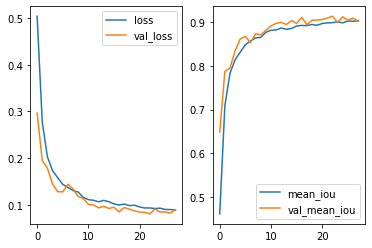

In [32]:
import matplotlib.pyplot as plt

x = range(len(results.history['loss']))
plt.subplot(121)
plt.plot(x, results.history['loss'], label='loss')
plt.plot(x, results.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(122)
plt.plot(x, results.history['mean_iou'], label='mean_iou')
plt.plot(x, results.history['val_mean_iou'], label='val_mean_iou')
plt.legend()

plt.show()

## Make predictions

In [35]:
model = load_model('C:/Users/sinjy/jupyter_notebook/model/model-dsbow', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(
        resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), 
               mode='constant', preserve_range=True))

3/3 [==============================] - 2s 596ms/step


In [39]:
preds_test.shape

(65, 128, 128, 1)

### check train data

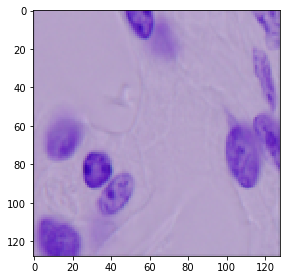

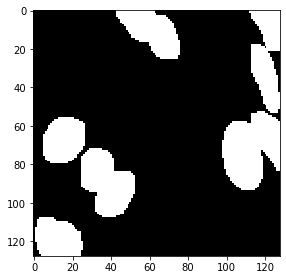

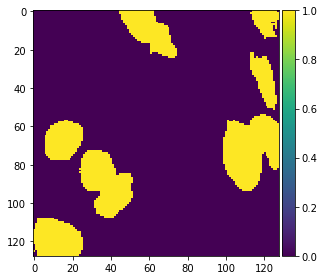

In [36]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

### check validation data

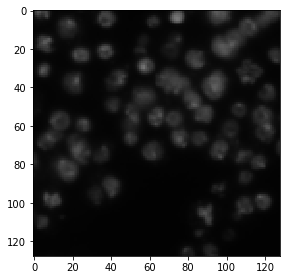

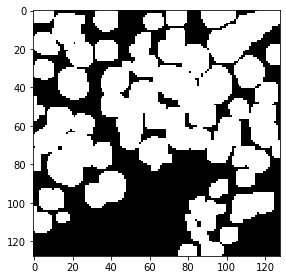

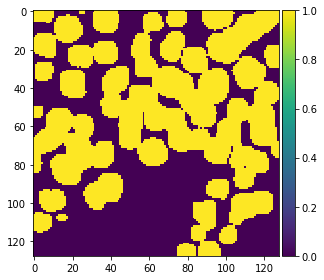

In [37]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

## Encode and submit our results

In [40]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [42]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [58]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(ROOT_DIR / 'kaggle_predict' / 'sub-dsbow.csv', index=False)